In [374]:
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from hBeta import PThBeta
import seaborn as sns
import pathlib
import collections
from utils.utils_func import load_database, _inv_transform, sample_pca_residuals_distribution, save_xls
from preprocessing import epi_year_cases_matrix
import matplotlib.lines as mlines
from collections import defaultdict
from utils.utils_func import _sim_square_pos
from lalonde import _subset_load_lalonde
from sklearn.linear_model import LogisticRegression, LinearRegression, Lasso
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA
from causallib.estimation import StratifiedStandardization, Standardization
from sklearn.ensemble import RandomForestRegressor
from utils.utils_summary import _dyadic_cube_to_samples, _dyadic_prediction, _dyadic_cube_to_samples222


sns.set_style("whitegrid")

### Load dataset and results of the simulation

In [375]:
DIR_LAN = 'C:\\Users\\itaym\\Google Drive\\University - Itay\\Msc\\Thesis\\Epi\\Results\\Sub_Lalonde\\'

def _load_pickle(file=('3_9_1_org'), data='X_sub_lalonde'):
    dir = DIR_LAN
    file = dir + data + '_' + file + '.pickle'
    with (open(file, "rb")) as openfile:
        d_res, d_info = pickle.load(openfile)
    return d_res, d_info

d_res, d_info = _load_pickle(file=('3_9_1_gamma_02'))

In [376]:
X, y, a = _subset_load_lalonde()

In [377]:
df_ipw = pd.DataFrame({'y':y, 'a':a})
df_ipw['prop'] = 0
df_ipw['prop_RCT'] = 0

tr_prop, cr_prop = np.mean(a), 1-np.mean(a)
df = pd.DataFrame({'control': d_res['control']['pi'], 'treated': d_res['treated']['pi']})
df_sum_y = np.sum(df, axis=1)
propensity = (df['treated'] * tr_prop) / (df['control'] * cr_prop + df['treated'] * tr_prop)
propensity_RCT = (df['treated'] * 0.5) / (df['control'] * 0.5 + df['treated'] * 0.5)

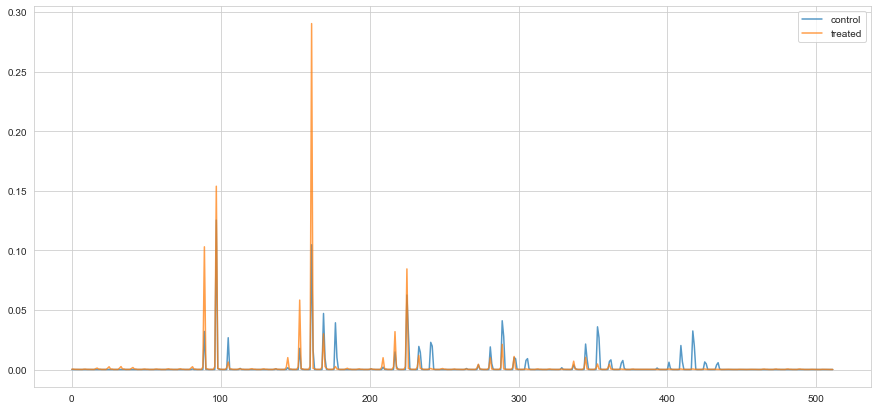

In [378]:
plt.subplots(figsize=(15,7))
plt.plot(np.arange(2 ** d_info['level']), d_res['control']['pi'], label='control', alpha = 0.75)
plt.plot(np.arange(2 ** d_info['level']), d_res['treated']['pi'], label='treated', alpha = 0.75)
plt.legend()

### Define the PThBeta space

In [379]:
pt = PThBeta(seg_1dim=d_info['seg_1dim'])
pt.set_int_coords(data=X, gamma=d_info['gamma'], sup_01=False)

In [380]:
dyadic_sample = _dyadic_cube_to_samples(X, pt)
dyadic_counts = defaultdict(dict)
for key in np.arange(2 ** d_info['level']):
    if dyadic_sample[key].shape[0] == 0:
        dyadic_sample.pop(key, None)
    else: 
        dyadic_counts['full'][key] = dyadic_sample[key].shape[0]
        
        ## really confused if it needs to be loc or iloc
        dyadic_counts['control'][key] = np.sum(a.loc[dyadic_sample[key]] == 0.0) # I changed to loc insted of iloc
        dyadic_counts['treatment'][key] = np.sum(a.loc[dyadic_sample[key]] == 1.0) # I changed to loc insted of iloc
        #  add this in order to compute IPTW
        ind_c = dyadic_sample[key]
#         ind_t = a.iloc[dyadic_sample[key]].index[(a.iloc[dyadic_sample[key]] == 1.0).values]
        df_ipw.loc[ind_c, 'prop'] =  propensity[key]
        df_ipw.loc[ind_c, 'prop_RCT'] =  propensity_RCT[key]
        df_ipw.loc[ind_c, 'ind_cube'] = int(key)

df_ipw['weights'] = df_ipw.loc[:,'prop'].rdiv(1.0)
df_ipw['weights_0'] = (1-df_ipw.loc[:,'prop']).rdiv(1.0)
df_ipw['weights_RCT'] = df_ipw.loc[:,'prop_RCT'].rdiv(1.0)
df_ipw['weights_0_RCT'] = (1-df_ipw.loc[:,'prop_RCT']).rdiv(1.0)
df_counts = pd.DataFrame.from_dict(dyadic_counts)
df_counts['prop'] = propensity.iloc[df_counts.index]
df_counts['prop_RCT'] = propensity_RCT.iloc[df_counts.index]
df_counts.sort_values(by='prop', ascending=True).iloc[:4,:]

,full,control,treatment,prop,prop_RCT
418,441,438,3,0.000075,0.008949
417,710,703,7,0.000119,0.013817
354,587,583,4,0.000119,0.013893
242,433,428,5,0.000129,0.015160


In [383]:
df_counts.loc[369,:]
df_ipw

,y,a,prop,prop_RCT,ind_cube,weights,weights_0,weights_RCT,weights_0_RCT
16827,31.03226,0.0,0.010246,0.550781,97.0,97.596426,1.010352,1.815603,2.226087
5412,19562.14000,0.0,0.000134,0.015656,290.0,7443.307897,1.000134,63.875244,1.015905
15399,25564.67000,0.0,0.004337,0.340332,289.0,230.557608,1.004356,2.938307,1.515914
13077,18814.41000,0.0,0.026962,0.766602,153.0,37.088851,1.027709,1.304459,4.284519
2189,0.00000,0.0,0.017853,0.683105,217.0,56.013675,1.018177,1.463903,3.155624
...,...,...,...,...,...,...,...,...,...
11964,678.27650,0.0,0.010246,0.550781,97.0,97.596426,1.010352,1.815603,2.226087
21575,1053.61900,0.0,0.000205,0.023834,226.0,4874.263800,1.000205,41.956466,1.024416
5390,21731.45000,0.0,0.000075,0.008949,418.0,13347.029435,1.000075,111.740835,1.009030
860,13151.76700,0.0,0.011276,0.574219,225.0,88.682003,1.011405,1.741497,2.348624


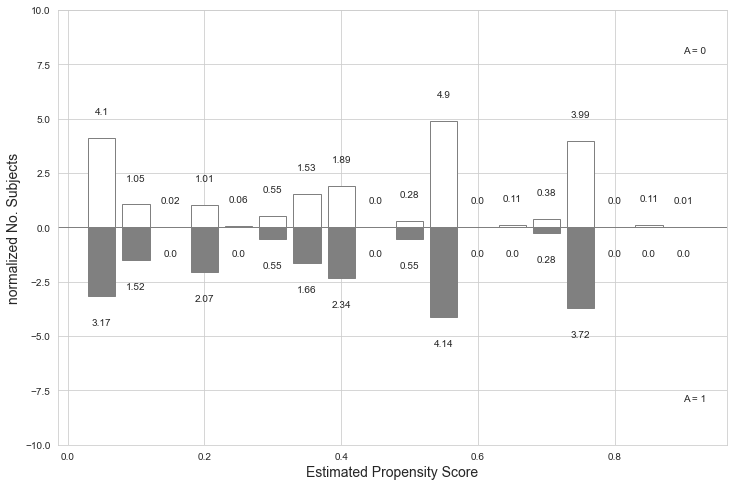

In [356]:
bins = np.arange(0.025, 0.975, 0.05)

top0, _ = np.histogram(df_ipw.loc[df_ipw['a']==0, 'prop_RCT'], bins=bins, density=True)
top1, _ = np.histogram(df_ipw.loc[df_ipw['a']==1, 'prop_RCT'], bins=bins, density=True)

fig, ax = plt.subplots(figsize=(12, 8))

ax.set_ylim(-10, 10)

ax.axhline(0, c='gray', linewidth=1)

bars0 = ax.bar(bins[:-1] + 0.025, top0, width=0.04, facecolor='white')
bars1 = ax.bar(bins[:-1] + 0.025, -top1, width=0.04, facecolor='gray')

for bars in (bars0, bars1):
    for bar in bars:
        bar.set_edgecolor("gray")

for x_, y_ in zip(bins, top0):
    ax.text(x_ + 0.025, y_ + 1, str(round(y_,2)), ha='center', va='bottom')

for x_, y_ in zip(bins, top1):
    ax.text(x_ + 0.025, -y_ - 1, str(round(y_,2)), ha='center', va='top')

ax.text(0.9,  8, "A = 0")
ax.text(0.9, -8, "A = 1")

ax.set_ylabel("normalized No. Subjects", fontsize=14)
ax.set_xlabel("Estimated Propensity Score", fontsize=14);


(array([[3.71783467, 1.16182334, 0.29045583, 1.16182334, 0.75518517,
         1.45227917, 0.5228205 , 1.10373217, 0.58091167, 0.        ],
        [4.01959551, 0.730479  , 0.13285893, 1.09277697, 0.59811032,
         1.5340059 , 0.72263493, 1.31633296, 0.57751964, 0.0225517 ]]),
 array([0.00894928, 0.10199966, 0.19505005, 0.28810043, 0.38115082,
        0.4742012 , 0.56725159, 0.66030197, 0.75335236, 0.84640274,
        0.93945312]),
 <a list of 2 BarContainer objects>)

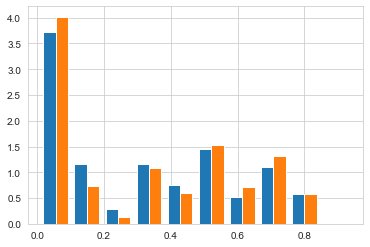

In [357]:
plt.hist([df_ipw['prop_RCT'].loc[df_ipw['a'] == 1], df_ipw['prop_RCT'].loc[df_ipw['a'] == 0]], density=True )

### Exploring conditional distribution on 2 d (without scaling)

                age     education           wage
count  22106.000000  22106.000000   22106.000000
mean      32.678685     11.856917   13283.157088
std       11.212404      2.888554   10000.159841
min       16.000000      0.000000       0.000000
25%       23.000000     10.000000    3581.174987
50%       30.000000     12.000000   13183.702500
75%       42.000000     13.000000   22049.445000
max       55.000000     18.000000  146900.955000


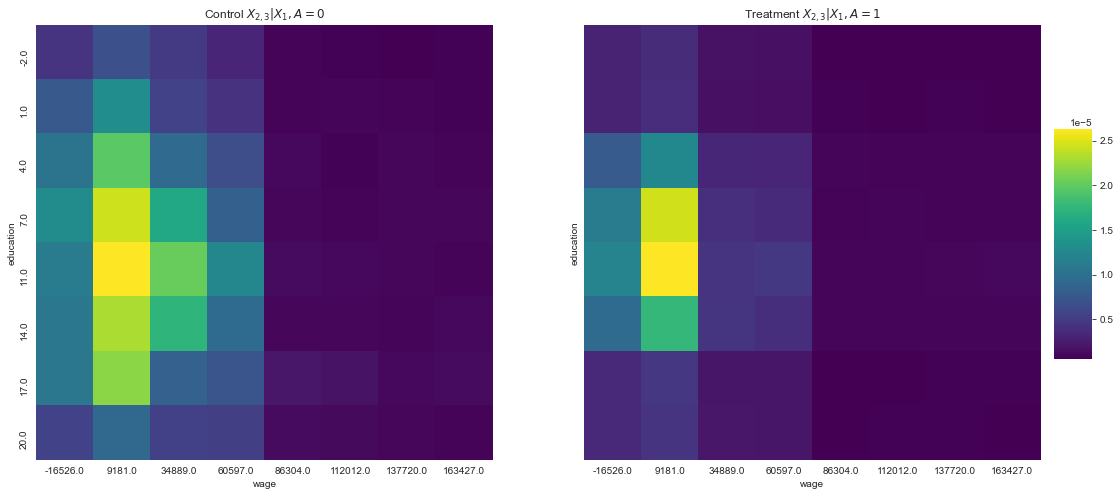

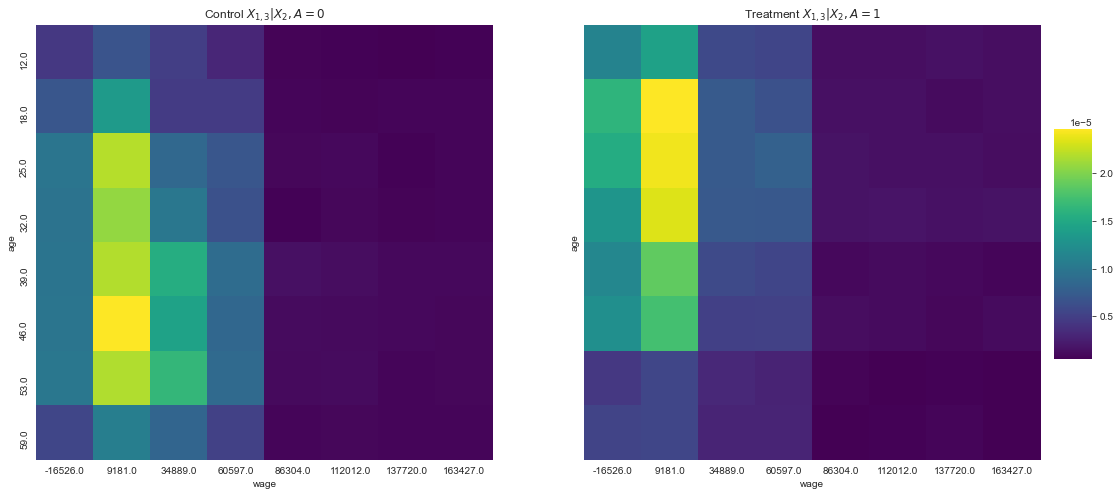

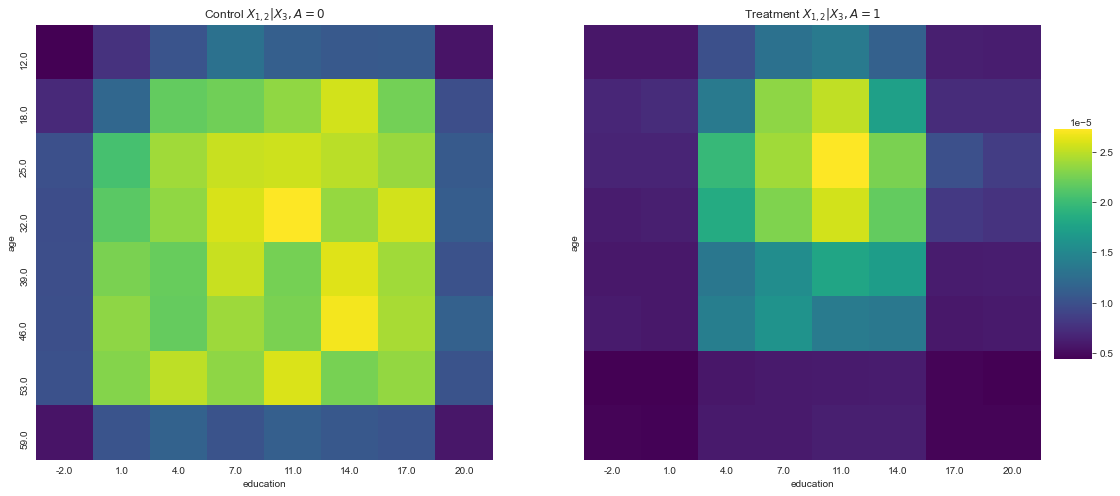

In [358]:
print(X.describe())

fig, axn = plt.subplots(ncols=2, figsize=(18, 8), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for i, ax in enumerate(axn.flat):
    if i == 0:
        df_temp = pd.concat([pd.Series(d_res['control']['pi'][:64], name='pi'), 
                             pd.DataFrame(np.around(pt.arr_med[:64, 1:3]),columns=X.columns[1:3])], axis=1)
        df_heat = df_temp.pivot('education', 'wage', "pi")
        ax.set_title('Control $X_{2,3}|X_{1},A=0$')
    else:
        df_temp = pd.concat([pd.Series(d_res['treated']['pi'][:64], name='pi'), 
                             pd.DataFrame(np.around(pt.arr_med[:64, 1:3]), columns=X.columns[1:3])], axis=1)
        df_heat = df_temp.pivot('education', 'wage', "pi")
        ax.set_title('Treatment $X_{2,3}|X_{1},A=1$')
    sns.heatmap(df_heat, ax=ax, 
                cbar=i == 0,vmin=df_temp['pi'].min(), vmax=df_temp['pi'].max(),
                cbar_ax=None if i else cbar_ax,cmap = plt.get_cmap('viridis'))
        
fig, axn = plt.subplots(ncols=2, figsize=(18, 8), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

ind = np.concatenate([np.arange(i*64,i*64+8) for i in range(8)])
for i, ax in enumerate(axn.flat):
    if i == 0:
        df_temp = pd.concat([pd.Series(d_res['control']['pi'][ind], name='pi'), 
                             pd.DataFrame(np.around(np.vstack((pt.arr_med[ind, 0] , pt.arr_med[ind, 2])).T),
                                          columns=X.columns[[0, 2]])], axis=1)
        df_heat = df_temp.pivot('age', 'wage', "pi")
        ax.set_title('Control $X_{1,3}|X_{2},A=0$')
    else:
        df_temp = pd.concat([pd.Series(d_res['treated']['pi'][ind], name='pi'), 
                             pd.DataFrame(np.around(np.vstack((pt.arr_med[ind, 0] , pt.arr_med[ind, 2])).T),
                                          columns=X.columns[[0, 2]])], axis=1)
        df_heat = df_temp.pivot('age', 'wage', "pi")
        ax.set_title('Treatment $X_{1,3}|X_{2},A=1$')
    sns.heatmap(df_heat, ax=ax, 
                cbar=i == 0, vmin=df_temp['pi'].min(), vmax=df_temp['pi'].max(),
                cbar_ax=None if i else cbar_ax,cmap = plt.get_cmap('viridis'))
        
fig, axn = plt.subplots(ncols=2, figsize=(18, 8), sharey=True, sharex=True)
cbar_ax = fig.add_axes([.91, .3, .03, .4])

ind = np.arange(0,512, 8)
for i, ax in enumerate(axn.flat):
    if i == 0:
        df_temp = pd.concat([pd.Series(d_res['control']['pi'][ind], name='pi'), 
                             pd.DataFrame(np.around(pt.arr_med[ind, 0:2]),columns=X.columns[0:2])], axis=1)
        df_heat = df_temp.pivot('age', 'education', "pi")
        ax.set_title('Control $X_{1,2}|X_{3},A=0$')
    else:
        df_temp = pd.concat([pd.Series(d_res['treated']['pi'][ind], name='pi'), 
                             pd.DataFrame(np.around(pt.arr_med[ind, 0:2]), columns=X.columns[0:2])], axis=1)
        df_heat = df_temp.pivot('age', 'education', "pi")
        ax.set_title('Treatment $X_{1,2}|X_{3},A=1$')
    sns.heatmap(df_heat, ax=ax, 
                cbar=i == 0,vmin=df_temp['pi'].min(), vmax=df_temp['pi'].max(),
                cbar_ax=None if i else cbar_ax,cmap = plt.get_cmap('viridis'))

# Computing IPW on the treated

In [373]:
treated_cubes = df_counts.loc[df_counts['treatment']>0].index
df_ipw_treated = df_ipw.loc[df_ipw['ind_cube'].isin(list(treated_cubes)),:].copy()

mu_1 = np.average(df_ipw_treated.loc[df_ipw_treated['a']==1, 'y'], weights=df_ipw_treated.loc[a==1,'weights_RCT'])
mu_0 = np.average(df_ipw_treated.loc[df_ipw_treated['a']==0, 'y'], weights=df_ipw_treated.loc[a==0,'weights_RCT'])

mu_0


14743.996501066018

In [361]:
treated_cubes = df_counts.loc[df_counts['treatment']>0].index

df_ipw_treated = df_ipw.loc[df_ipw['ind_cube'].isin(list(treated_cubes)),:].copy()

In [371]:
df_ipw_treated.loc[df_ipw_treated['a']==1]

df_ipw_treated.loc[a==1,'weights_RCT']



134     4032.708
44      3972.540
34      3191.753
133     6943.342
139    13385.860
         ...    
77         0.000
117     1652.637
55         0.000
9      12418.070
161     7382.549
Name: y, Length: 185, dtype: float64

In [351]:
df_ipw.loc[df_ipw['a']==1,'ind_cube']#.isin(treated_cubes)

134    345.0
44      97.0
34     170.0
133    281.0
139    417.0
       ...  
77     290.0
117    226.0
55     369.0
9      281.0
161    105.0
Name: ind_cube, Length: 185, dtype: float64

In [349]:
treated_cubes

Int64Index([ 89,  97, 105, 145, 153, 161, 169, 170, 177, 209, 217, 225, 233,
            273, 281, 289, 297, 337, 345, 353, 361],
           dtype='int64')

In [327]:
df_ipw_treated.loc[df_ipw_treated['a']==1]

np.sum(df_ipw['a']==1)

185

In [332]:
df_counts.loc[df_counts['treatment']>0]

df_counts

,full,control,treatment,prop,prop_RCT
73,2,2,0,0.072571,0.902832
81,10,10,0,0.042877,0.841309
89,727,704,23,0.026505,0.763184
90,3,3,0,0.041840,0.836914
97,2784,2752,32,0.010246,0.550781
...,...,...,...,...,...
427,1,1,0,0.019241,0.699707
433,88,88,0,0.000353,0.040802
434,127,127,0,0.000158,0.018478
435,9,9,0,0.002235,0.210205


In [321]:
df_ipw.loc[df_ipw['ind_cube'].isin(list(treated_cubes)),:].copy()

,y,a,prop,prop_RCT,weights,weights_RCT,weights_0,weights_0_RCT,ind_cube
16827,31.03226,0.0,0.010246,0.550781,97.596426,1.815603,1.010352,2.226087,97.0
15399,25564.67000,0.0,0.004337,0.340332,230.557608,2.938307,1.004356,1.515914,289.0
13077,18814.41000,0.0,0.026962,0.766602,37.088851,1.304459,1.027709,4.284519,153.0
2189,0.00000,0.0,0.017853,0.683105,56.013675,1.463903,1.018177,3.155624,217.0
5504,24883.44000,0.0,0.004391,0.343018,227.753258,2.915302,1.004410,1.522111,281.0
...,...,...,...,...,...,...,...,...,...
4426,12522.25000,0.0,0.001086,0.114136,920.611062,8.761497,1.001087,1.128841,353.0
16850,0.00000,0.0,0.003998,0.322021,250.137405,3.105383,1.004014,1.474973,345.0
6265,20162.10000,0.0,0.003998,0.322021,250.137405,3.105383,1.004014,1.474973,345.0
11964,678.27650,0.0,0.010246,0.550781,97.596426,1.815603,1.010352,2.226087,97.0


In [212]:
def compute_weight_matrix(self, X, a, truncate_eps=None, use_stabilized=None):
    """
    Computes individual weight across all possible treatment values.
    w_ij = 1 / Pr[A=a_j | X_i]  for all individual i and treatment j.
    Args:
        X (pd.DataFrame): Covariate matrix of size (num_subjects, num_features).
        a (pd.Series): Treatment assignment of size (num_subjects,).
        truncate_eps (None|float): Optional value between 0 to 0.5 to clip the propensity estimation.
                                   Will clip probabilities between clip_eps and 1-clip_eps.
        use_stabilized (None|bool): Whether to re-weigh the learned weights with the prevalence of the treatment.
                                    This overrides the use_stabilized parameter provided at initialization.
                                    If True provided, but the model was initialized with use_stabilized=False, then
                                    prevalence is calculated from data at hand, rather than the prevalence from the
                                    training data.
                                    See Also: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4351790/#S6title
    Returns:
        pd.DataFrame: A matrix of size (num_subjects, num_treatments) with weight for every individual and every
                      treatment.
    """

    probabilities = self.compute_propensity_matrix(X, a, truncate_eps)

    # weight_matrix = 1.0 / probabilities                                                     # type: pd.DataFrame
    weight_matrix = probabilities.rdiv(1.0)

    if use_stabilized:
        if self.use_stabilized:
            prevalence = self.treatment_prevalence_
        else:
            warnings.warn("Stabilized is asked, however, the model was not trained using stabilization, and "
                          "therefore, stabilized weights are taken from the provided treatment assignment.",
                          RuntimeWarning)
            prevalence = a.value_counts(normalize=True, sort=False)
        prevalence_per_subject = a.replace(prevalence)  # map tx-assign to prevalence
        # pointwise multiplication of each column in weights:
        weight_matrix = weight_matrix.multiply(prevalence_per_subject, axis="index")

    return weight_matrix

Index(['age', 'wage'], dtype='object')

In [232]:
probabilities = df_ipw['prop_RCT']
weight_matrix = probabilities.rdiv(1.0)

In [233]:
prevalence = a.value_counts(normalize=True, sort=False)
prevalence_per_subject = a.replace(prevalence)
weight_matrix = weight_matrix.multiply(prevalence_per_subject, axis="index")                                 

In [249]:
df_ipw

,y,a,prop,prop_RCT,weights,weights_RCT,weights_0,weights_0_RCT
16827,31.03226,0.0,0.010246,0.550781,97.596426,1.815603,1.010352,2.226087
5412,19562.14000,0.0,0.000134,0.015656,7443.307897,63.875244,1.000134,1.015905
15399,25564.67000,0.0,0.004337,0.340332,230.557608,2.938307,1.004356,1.515914
13077,18814.41000,0.0,0.026962,0.766602,37.088851,1.304459,1.027709,4.284519
2189,0.00000,0.0,0.017853,0.683105,56.013675,1.463903,1.018177,3.155624
...,...,...,...,...,...,...,...,...
11964,678.27650,0.0,0.010246,0.550781,97.596426,1.815603,1.010352,2.226087
21575,1053.61900,0.0,0.000205,0.023834,4874.263800,41.956466,1.000205,1.024416
5390,21731.45000,0.0,0.000075,0.008949,13347.029435,111.740835,1.000075,1.009030
860,13151.76700,0.0,0.011276,0.574219,88.682003,1.741497,1.011405,2.348624


In [288]:
aggregated_value = np.average(y.loc[(a==1) & (df_ipw.loc[:,'prop_RCT']> 0.05)], 
                              weights=df_ipw.loc[(a==1) & (df_ipw.loc[:,'prop_RCT']> 0.05),'weights_RCT'])

In [271]:
from causallib.evaluation.plots import plot_propensity_score_distribution

C:\Users\itaym\Anaconda3\envs\src\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\itaym\Anaconda3\envs\src\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Propensity Distribution'}, xlabel='Propensity', ylabel='Probability density'>

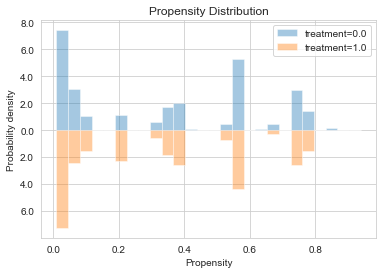

In [274]:
plot_propensity_score_distribution(df_ipw['prop_RCT'],a)

In [279]:
np.sum(df_ipw.loc[:,'prop_RCT']> 0.05)

16051

In [292]:
X.loc[a==1]

,age,education,wage
134,24.0,11.0,1245.2508
44,20.0,11.0,0.0000
34,25.0,12.0,0.0000
133,20.0,11.0,8901.8070
139,26.0,11.0,1113.1330
...,...,...,...
77,21.0,9.0,0.0000
117,20.0,12.0,188.7843
55,17.0,10.0,0.0000
9,33.0,12.0,0.0000


In [258]:
np.mean(y.loc[a==0] * df_ipw.loc[a==0,'weights_0_RCT'])

27971.492210765657

In [262]:
np.sum(df_ipw.loc[a==0,'weights_0'])


np.sum(df_ipw.loc[a==1,'weights'])

386648.9176356414

In [285]:
np.mean(y.loc[a==1] * df_ipw.loc[(a==1) & (df_ipw.loc[:,'prop_RCT']> 0.05),'weights_RCT'])

33417.635616490516

In [290]:
print(aggregated_value)

np.average(y.loc[(a==0) & (df_ipw.loc[:,'prop_RCT']> 0.05)],
           weights=df_ipw.loc[(a==0) & (df_ipw.loc[:,'prop_RCT']> 0.05),'weights_0_RCT'])

7504.41020868512


14653.220075645653

In [242]:
sample_weight = pd.Series(data=1.0, index=y.index)
res = {}
for treatment_value in [0,1]:
    subgroup_mask = stratify_by == treatment_value
    aggregated_value = np.average(y[subgroup_mask], weights=sample_weight[subgroup_mask])
    res[treatment_value] = aggregated_value
res = pd.Series(res)

NameError: name 'stratify_by' is not defined